In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error

from helper_functions import find_outlier_games, kfold_validate_score, kfold_validate_pred, var_plot

In [2]:
# Import processed data from EDA notebook
bgg = pd.read_csv('./data/bgg_processed.csv', index_col='game_id')

In [3]:
# Split off target column: `avg_rating`
y = bgg['avg_rating']
X = bgg.drop('avg_rating', axis=1).copy()

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Initial linear regression

First let's see how simple linear regression fares. There are 2000 entries in the original data, so the train/test split leaves 1600 rows in the training data. 8 splits for K-Fold cross validation should ve sufficient so each slice is 200 rows. The rows were already shuffled with the train/test split, so they don't need shuffled again.

In [5]:
# Find mean RMSE through linear regression over 8 fold
linear = LinearRegression().fit(X_train, y_train)

kfold_validate_score(X_train, y_train, model=linear)

0.2900673749246467

Clearly, something isn't optimal. The range between the minimum score and maximum score is 2.7 points. We'd want the average RMSE to be smaller than this range, not 20 billion.

In [6]:
# Create the scores used by the previous function
training = -1 * cross_val_score(
    linear,
    X_train,
    y_train,
    scoring='neg_root_mean_squared_error',
    cv=KFold(n_splits=8)
)

In [7]:
training.mean()

20290175055.225716

In [8]:
linear_preds = linear.predict(X_train)

In [9]:
avg_rmse = mean_squared_error(y_train, linear_preds, squared=False)
avg_rmse

0.2900673749246467

In [10]:
# # Look at scores from each split
# for i in training:
#     score = np.sqrt(i)
#     print(f'Slice {list(scores).index(i)} RMSE: {score}')

There is something in the 8th slice that is going wrong. Let's dig in a little to see what it is. First, we need to see what the CV is actually predicting:

In [11]:
# Generate predictions from the cross validation
preds = kfold_validate_pred(X_train, y_train, model=linear)

# show the min and max predictions
print(f'Max prediction: {np.max(preds)}\nMin prediction: {np.min(preds)}')

Max prediction: 11.409906691914584
Min prediction: -2295571259637.283


It looks like the highest prediction is within reason. Ideally, we'd want it below 10, but it isn't too far off. The algorithm certainly doesn't know the BGG ratings should be in the 0-10 range.

The lowest prediction, however, is far from where it should be.

In [12]:
# Find index of smallest prediction in X_train
outlier_idx = X_train.iloc[[list(preds).index(np.min(preds))]].index[0]
outlier_idx

46213

In [13]:
# Load the names df
names = pd.read_csv('./data/bgg_names.csv', index_col='game_id')

In [14]:
# Find name of game causing the issue
names.loc[outlier_idx][0]

'Telestrations'

The model is predicting a very anomalous result for the game called "Telestrations". Is this a result that is specific for 8 k-fold slices?

In [15]:
# find_outlier_games returns {Game Name: Predicted Score} for any game
# where predicted score is -20 < score < 20
for i in range(2, 21):
    outliers = find_outlier_games(X_train, y_train, names, i)
    print(f'{i} folds - Outlier games:')
    print('\t', outliers)

TypeError: Cannot clone object '2' (type <class 'int'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

### Prediction outliers

Depending on the amount of folds used, there can be more than one game receiving extreme predictions. However, no matter how many folds used, "Telestrations" always receives an extreme prediction.

This shows there is a fundamental problem with a basic Linear Regression model and corrective measures need taken somewhere.

#### "Telestrations" options:
 1) Remove it from analysis
 2) Use a method, such as Principle Component Regression or Princible Least Squares Regression, to reduce the features the Linear Regression model predicts off.

Some form of component reduction would be preferable if it would eliminate the need to remove games with anomalous predictions. It would be a big risk removing a problem game. First, that would lead to overfitting of the test data. Also there are many folds with more games not receiving acceptable predictions. There are certainly many more games simple Linear Regression will predict incorrectly.

### Removing "Telestrations"

First, let's see how the data fares without "Telestrations". This will at least allow us to see what Linear Regression will predict in a perfect scenerio with no games receiving outling predictions.

In [16]:
# Remove "Telestrations"

# Find Index
tele_idx = names[names['name']=="Telestrations"].index[0]

# Remove Game
X_train_no_tele = X_train.drop(index=tele_idx, axis=1).copy()
y_train_no_tele = y_train.drop(index=tele_idx, axis=1).copy()

In [18]:
# Find RMSE without "Telestrations"
linear_no_tele = LinearRegression().fit(X_train_no_tele, y_train_no_tele)

rmse_no_tele = kfold_validate_score(X_train_no_tele, y_train_no_tele, model=linear_no_tele)
rmse_no_tele

0.29015806323878185

This is a much more reasonable RMSE. How does the reduced dataset perform on different slices?

In [ ]:
# find_outlier_games returns {Game Name: Predicted Score} for any game
# where predicted score is -20 < score < 20
for i in range(2, 21):
    outliers = find_outlier_games(X_train_no_tele, y_train_no_tele, names, i)
    print(f'{i} folds - Outlier games:')
    print('\t', outliers)

There are still a number of anomalous results with some fold selections, but the majority of fold selections produce acceptable results. Removing problem games clearly isn't an acceptable solution.

### Initial Linear regression thoughts

Linear regression by itself is not a good choice for the model. There is the possibility of predicting some exceedingly high or low predictions, depending on the training data used. There is also one game in the training data that absolutely is not predicted well. This has the potential to lead to very undesirable results in production.

## Lasso Regression

How do other methods of regression fare? First let's look at Lasso Regression:

In [19]:
# Find mean RMSE through lasso regression over 8 fold
lasso = LassoCV(random_state=42).fit(X_train, y_train)

lasso_rmse = kfold_validate_score(X_train, y_train, model=lasso)
lasso_rmse

0.30750968979087084

Lasso regression returns a better mean RMSE than simple linear regression with all the games.

### Without Telestrations

In [20]:
# Find mean RMSE through lasso regression over 8 fold - without "Telestrations"
kfold_validate_score(X_train_no_tele, y_train_no_tele, model=lasso)

0.3074962692941887

No improvement. Lasso regression works just as well with all the games. This is already a much better model.

## Ridge Regression

In [21]:
# Find mean RMSE through ridge regression over 8 fold
ridge = RidgeCV().fit(X_train, y_train)

ridge_rmse = kfold_validate_score(X_train, y_train, model=ridge)
ridge_rmse

0.29690849801637825

This method is even better than lasso or linear regression

## Principle Component Regression 

In [22]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

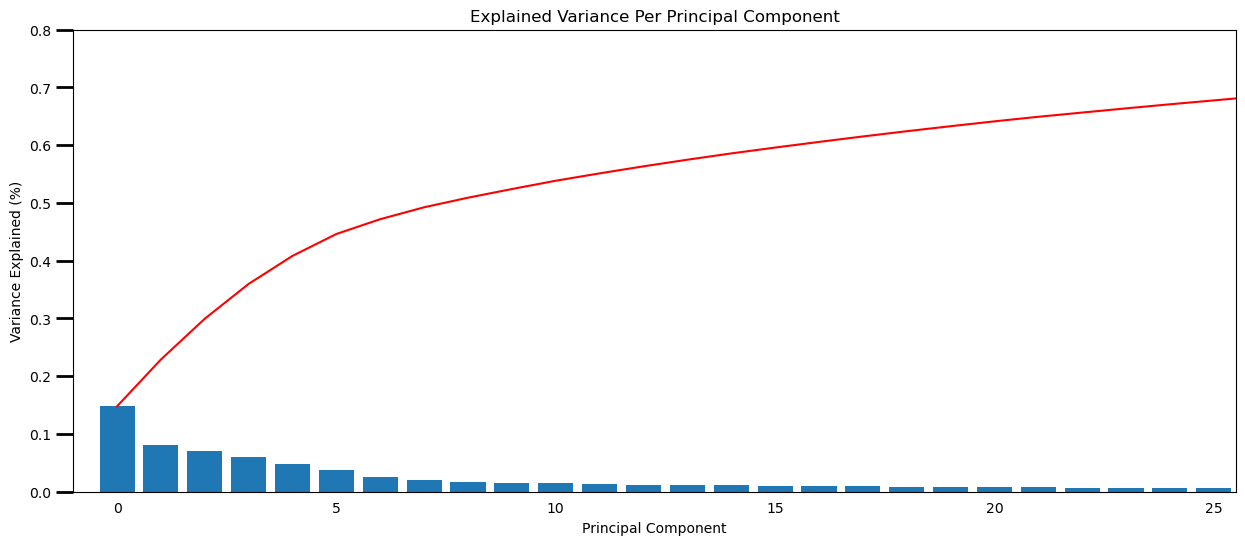

In [23]:
var_plot(pca)
plt.xlim(-1,25.5)
plt.ylim(0, 0.8);

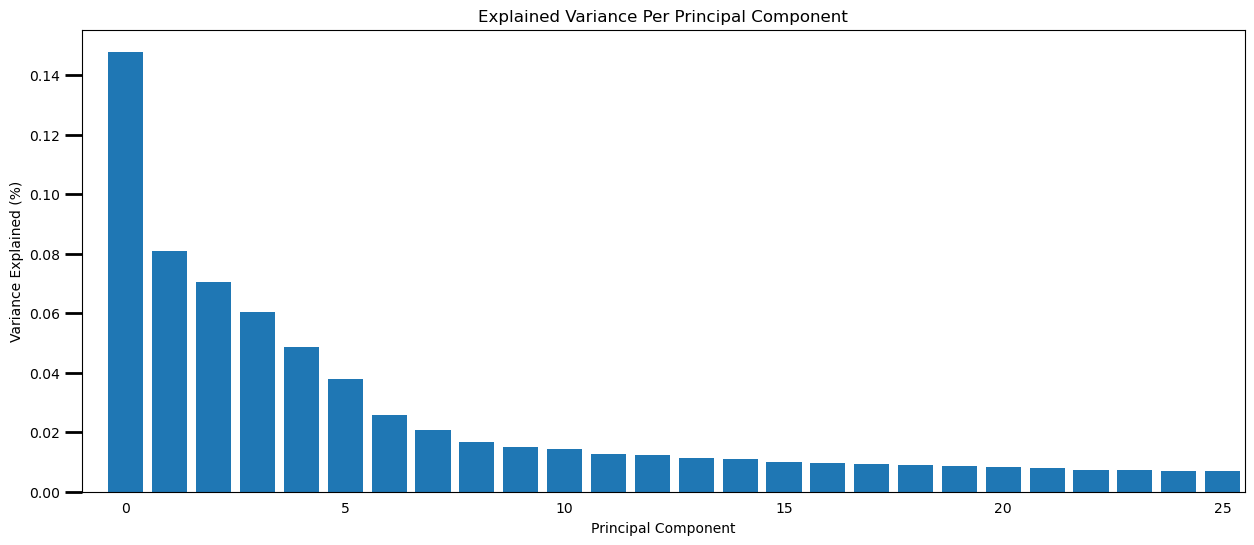

In [24]:
# Bar chart showing variance of PCA transformation with no paramaters
var_plot(pca, scree=False)

# Restrict the x-axis to allow a better view of the important data
plt.xlim(-1,25.5);

In [25]:
# Instatiate
pca_9 = PCA(9, random_state=42)

# Fit & Transform
X_train_reduced_9 = pca_9.fit_transform(X_train)

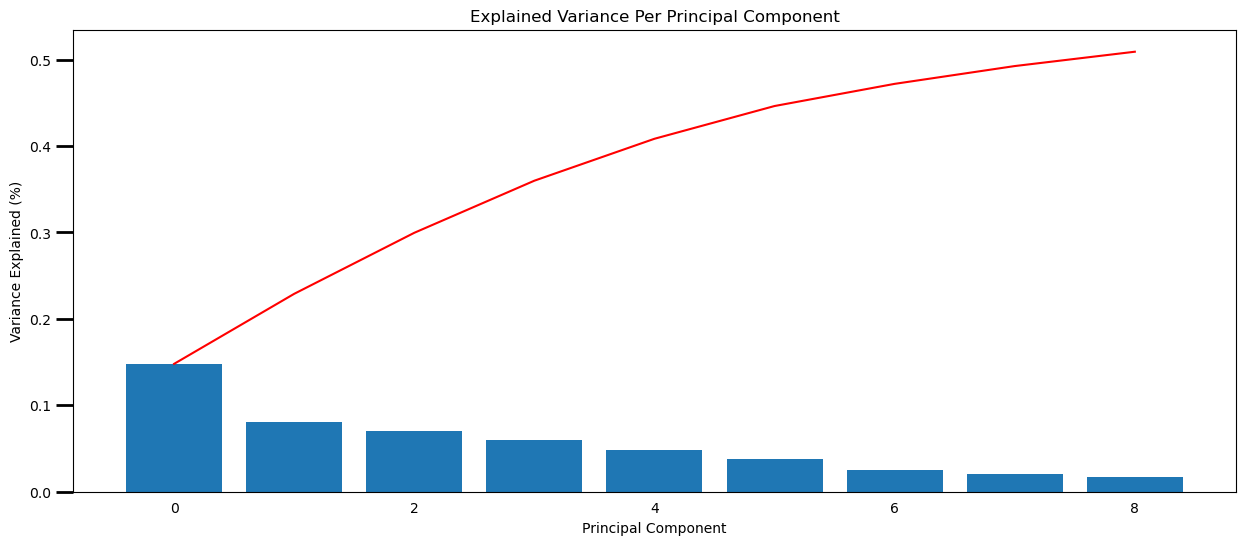

In [26]:
var_plot(pca_9)

In [27]:
# Total percentage of 9 principal components
pca_9.explained_variance_ratio_.sum()

0.5091366269665704

50% of the variance is explained by 9 PCA components.

In [31]:
# Find mean RMSE for 9 PCs
linear_pca = LinearRegression().fit(X_train_reduced_9, y_train)

kfold_validate_score(X_reduced[:,:9], y_train, model=linear_pca)

0.361978633055819

In [32]:
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    linear_pca = LinearRegression().fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=linear_pca)
    pca_rmses.append(rmse)

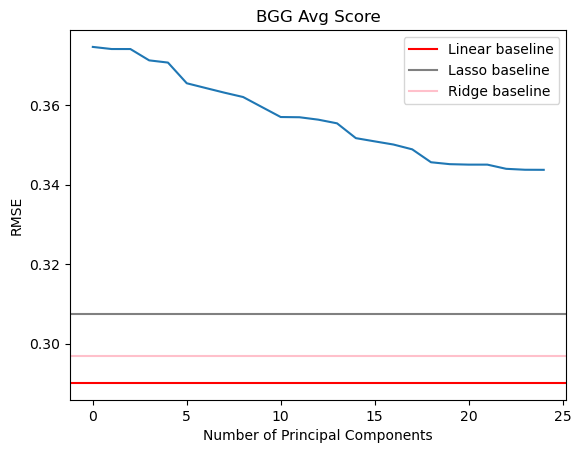

In [33]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

At 5 Principle Components, the model is outperforming the baseline (Simple Linear Regression with "Telestrations" removed). At 10 Principle Components, the MSE appears to be stabilizing, with no significant increase in performance with added Principle Components.

Also, this model is superior because no games have been ommited.

In [34]:
# Instatiate
pca_10 = PCA(10, random_state=42)

# Fit & Transformfrom sklearn.cross_decomposition import PLSRegression
X_train_reduced_10 = pca_10.fit_transform(X_train)

All games receive a resonable predictive score with PCR

In [35]:
# Try it with Lasso regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    lasso_pca = LassoCV(random_state=42).fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=lasso_pca)
    pca_rmses.append(rmse)

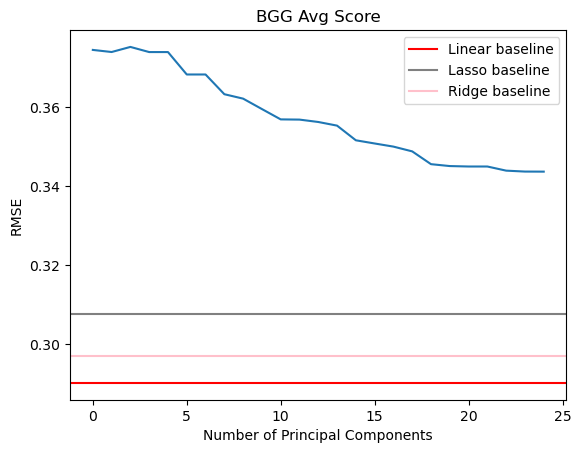

In [36]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [38]:
# Try it with Ridge regression
pca = PCA(random_state=42)

X_reduced = pca.fit_transform(X_train)

pca_rmses = []

#Check the first 25 principle components for RMSE
for i in np.arange(1,26):
    ridge_pca = RidgeCV().fit(X_reduced[:,:i], y_train)
    rmse = kfold_validate_score(X_reduced[:,:i], y_train, model=ridge_pca)
    pca_rmses.append(rmse)

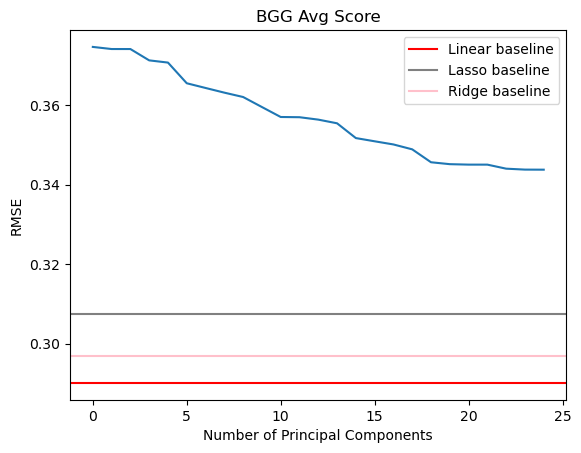

In [39]:
plt.plot(pca_rmses)

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

## Partial Least Squares Regression

In [40]:
pls = PLSRegression(n_components=10)
X_train_pls = pls.fit(X_train, y_train)

In [41]:
X_train_pls = pls.transform(X_train)

In [42]:
# Check mean RMSE for 10 PLS components
linear_pls = LinearRegression().fit(X_train_pls, y_train)

rmse_pls = kfold_validate_score(X_train_pls, y_train, model=linear_pls)
rmse_pls

0.2904510509768359

The RMSE is now below 0.30. This is a clear improvement using PLS.

In [44]:
linear_pls_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    linear_pls = LinearRegression().fit(X_train_pls, y_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train, model=linear_pls)
    
    linear_pls_rmses.append(rmse)

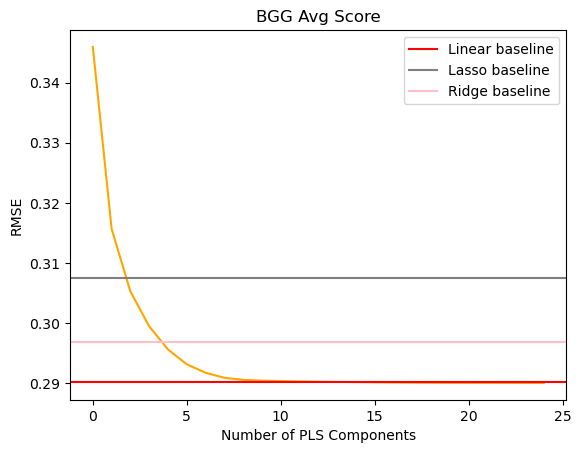

In [45]:
plt.plot(linear_pls_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

The "elbow" is around 4 PLS components, but the min is at 7 components, after which the RMSE starts increasing. This is a clear improvement over PCR.

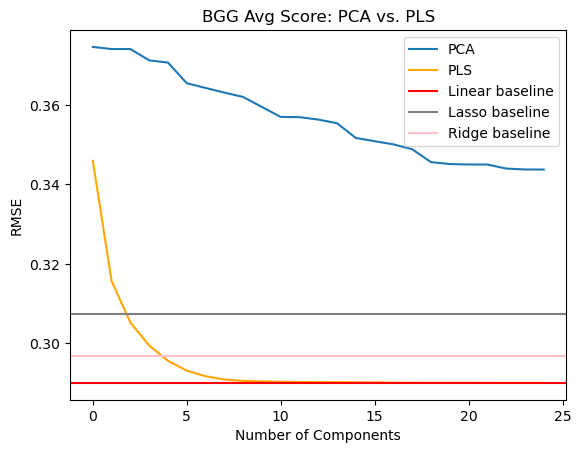

In [46]:
plt.plot(pca_rmses, label='PCA')
plt.plot(linear_pls_rmses, label='PLS', color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score: PCA vs. PLS');

Comparing the two reduction methods, PLS is the clear winner, reducing the RSME from the baseline by about 25%. PCA at its best remains around the baseline, only reducing it by about 4%

In [47]:
pls = PLSRegression(n_components=7)
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [48]:
# PLS regression with 7 components - Lasso regression model
lasso_pls = LassoCV(random_state=42).fit(X_train_pls, y_train)

rmse_pls_lasso = kfold_validate_score(X_train_pls, y_train, model=lasso_pls)
rmse_pls_lasso

0.2917637525211219

Like it was before feature reduction, lasso regression has an average RMSE of about 0.44

In [49]:
pls_lasso_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    lasso_pls = LassoCV(random_state=42).fit(X_train_pls, y_train)

    rmse = kfold_validate_score(X_train_pls, y_train, model=lasso_pls)
    
    pls_lasso_rmses.append(rmse)

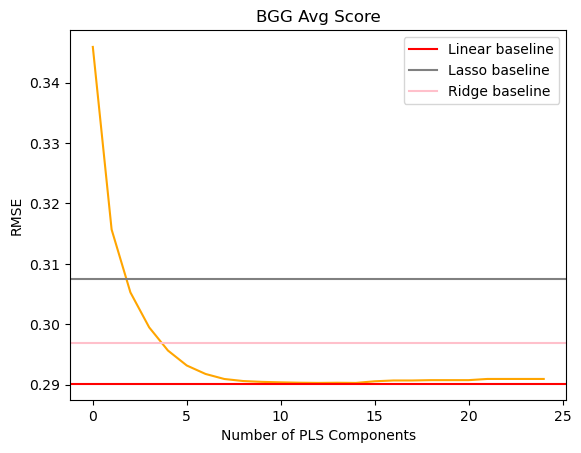

In [50]:
plt.plot(pls_lasso_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

There is no change to the mean RMSE depending on the number pf PLS Components

In [51]:
pls_ridge_rmses = []

#Check 1-25 PLS components for RMSE
for i in np.arange(1,26):
    pls = PLSRegression(n_components=i)

    X_train_pls = pls.fit(X_train, y_train)
    X_train_pls = pls.transform(X_train)

    ridge_pls = RidgeCV().fit(X_train_pls, y_train)
    
    rmse = kfold_validate_score(X_train_pls, y_train, model=ridge_pls)
    
    pls_ridge_rmses.append(rmse)

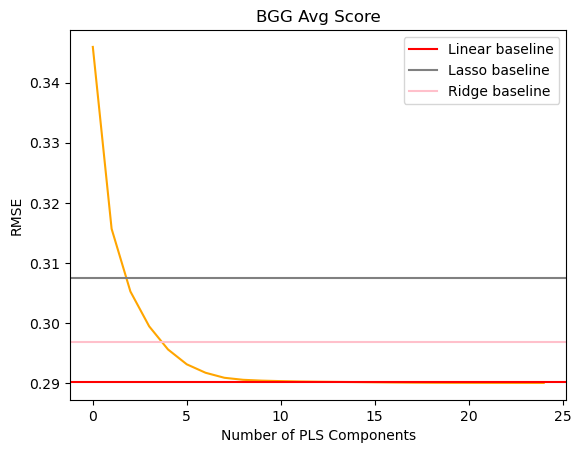

In [52]:
plt.plot(pls_ridge_rmses, color='orange')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

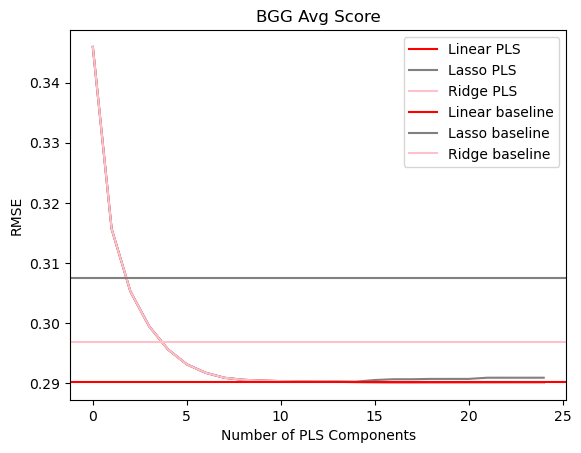

In [54]:
plt.plot(linear_pls_rmses, label='Linear PLS', color='red')
plt.plot(pls_lasso_rmses, label='Lasso PLS', color='grey')
plt.plot(pls_ridge_rmses, label='Ridge PLS', color='pink')

# add baselines
plt.axhline(rmse_no_tele, color='r', label='Linear baseline')
plt.axhline(lasso_rmse, color='grey', label='Lasso baseline')
plt.axhline(ridge_rmse, color='pink', label='Ridge baseline')

plt.legend()

plt.xlabel('Number of PLS Components')
plt.ylabel('RMSE')
plt.title('BGG Avg Score');

In [55]:
np.mean(linear_pls_rmses) - np.mean(pls_lasso_rmses)

-0.00028243546905210026

In [56]:
np.mean(linear_pls_rmses) - np.mean(pls_ridge_rmses)

-6.203136524440822e-07

In [57]:
np.mean(pls_lasso_rmses) - np.mean(pls_ridge_rmses)

0.0002818151553996562

# Final Model?

In [58]:
pls = PLSRegression(n_components=7)
X_train_pls = pls.fit(X_train, y_train)
X_train_pls = pls.transform(X_train)

In [68]:
model=LinearRegression()

In [69]:
model = model.fit(X_train_pls, y_train)

In [70]:
X_test_pls = pls.transform(X_test)

preds = model.predict(X_test_pls)

In [71]:
np.sqrt(mean_squared_error(y_test, preds))

0.3642844734281978

# Component Explanations

The components need looked at to help explain the model